#Comment this if not running on Google Colaboratory

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


#Importing Libraries

In [0]:
import cv2
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


import torch
import torch.nn as nn
import torch.nn.functional as F 
from torch.utils.data import DataLoader, TensorDataset
from torchvision.transforms.functional import normalize
from torch.utils.tensorboard import SummaryWriter

In [3]:
np.random.seed(0)
torch.manual_seed(0)

#Checking GPU existence

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


#Data Loading (Change the Path to CSV accordingly)

In [0]:
Path_to_CSV = '/content/gdrive/My Drive/Emotion Caps/fer2013.csv'

In [0]:
dataset_path = Path_to_CSV 
#Image size in this dataset is 48*48
image_size=(48,48)

In [0]:
def load_fer2013():

  data = pd.read_csv(dataset_path)
  pixels = data['pixels'].tolist()
  width, height = 48, 48
  faces = []
  for pixel_sequence in pixels:
      face = [int(pixel) for pixel in pixel_sequence.split(' ')]
      face = np.asarray(face).reshape(width, height)
      face = cv2.resize(face.astype('uint8'),image_size)
      faces.append(face.astype('float32'))
  faces = np.asarray(faces)
  faces = np.expand_dims(faces, -1)
  emotions = np.array(pd.get_dummies(data['emotion']))
  return faces, emotions



In [7]:

faces, emotions = load_fer2013()
faces = faces.reshape(-1, 1, 48, 48)
z = list(zip(faces, emotions))
random.shuffle(z)
faces[:], emotions[:] = zip(*z)

faces = faces[:35800, :, :, :]
emotions = emotions[:35800, :]

print(faces.shape)
print(emotions.shape)



(35800, 1, 48, 48)
(35800, 7)


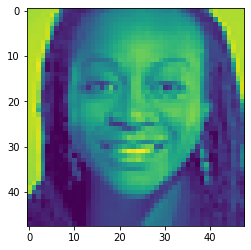

In [8]:
plt.imshow(faces[9000].reshape(48,48))

(35800,)


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Counter({0: 4829, 1: 481, 2: 5134, 3: 9002, 4: 6060, 5: 4230, 6: 6064})

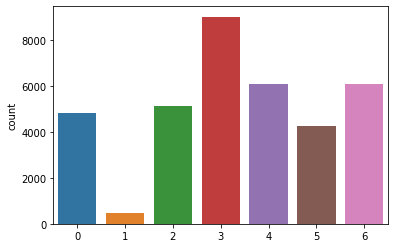

In [9]:
y = np.argmax(emotions, axis=1)
print(y.shape)
import seaborn as sns
import collections
g = sns.countplot(y)

collections.Counter(y)

#Data division (For Training and Testing)

In [0]:
X_train = faces[7162:,:, :,:]
X_test  = faces[:7162, :,:,:]
y_train = emotions[7162:, :]
y_test  = emotions[:7162, :]


In [0]:

X_train = torch.tensor(X_train, dtype=torch.float) / 255.0
X_test = torch.tensor(X_test, dtype=torch.float) / 255.0
y_train = torch.tensor(y_train, dtype = torch.float)
y_test = torch.tensor(y_test, dtype = torch.float)

y_test = y_test.type(torch.cuda.FloatTensor)
y_train = y_train.type(torch.cuda.FloatTensor)

In [0]:
bs = 50
epochs = 5

In [0]:
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader  = DataLoader(train_dataset, batch_size=bs, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=bs, shuffle=True)

In [14]:
print(len(train_loader))

573


#Model:

In [0]:
class capsNet(nn.Module):
  
  
  def __init__(self):
    super(capsNet, self).__init__()
    
    self.BN0 = nn.BatchNorm2d(1)
    
    self.conv1 = nn.Conv2d(1, 64, 7)
    self.BN1 = nn.BatchNorm2d(64)
    
    self.conv2 = nn.Conv2d(64, 128, 11)
    self.BN2 = nn.BatchNorm2d(128)
    
    self.conv3 = nn.Conv2d(128, 256, 15, 2)
    self.BN3 = nn.BatchNorm2d(256)
    
    
    self.trans_matrix2 = nn.Parameter(torch.randn(1, 648, 7, 64, 32))
    
    # Decoder Network::
    self.decoder = nn.Sequential(
        
            nn.BatchNorm1d(64*7),
        
            nn.Linear(64*7, 512),
            # nn.BatchNorm1d(512),
            nn.ReLU(inplace = True),
            nn.BatchNorm1d(512),
           
            nn.Linear(512, 1024),
            # nn.BatchNorm1d(1024),
            nn.ReLU(inplace = True),
            nn.BatchNorm1d(1024),
        
            nn.Linear(1024, 2048),
            # nn.BatchNorm1d(2048),
            nn.ReLU(inplace = True),
            nn.BatchNorm1d(2048),
        
            nn.Linear(2048, 48*48),
            # nn.BatchNorm1d(48*48),
            nn.Sigmoid()
            
    )
    
    self.MSE = nn.MSELoss()
  
  
  
  
  def forward(self, x, T, train = True, Purturb = False, Purturb_vec = None):
    
        batch_size = x.size(0)
    
        T = T.type(torch.cuda.FloatTensor)
      
        x = self.BN0(x)
      
        x = self.conv1(x)
        # x = self.BN1(x)
        x = F.relu(x)
        x = self.BN1(x)
        
        
        
        x = self.conv2(x)
        # x = self.BN2(x)
        x = F.relu(x)
        x = self.BN2(x)
        
        
        x = self.conv3(x)
        # x = self.BN3(x)
        x = F.relu(x)
        x = self.BN3(x)
        
        
        x = x.view(-1, 648, 1, 32, 1)
        x = self.squash(x, dim = -2)
        
        W = torch.cat([self.trans_matrix2] * batch_size, dim=0)
        
        x = x.repeat(1,1,7,1,1)
        x = torch.matmul(W, x)
        
      
        rout_weight = torch.zeros(batch_size, 648, 7 ,1 ,1, requires_grad = False)
        
        
        routing_weights1 = F.softmax(rout_weight, dim = 1)
        weighted_predictions = routing_weights1.type(torch.cuda.FloatTensor) * x.type(torch.cuda.FloatTensor)                   #
        weighted_sum = torch.sum(weighted_predictions, dim=1, keepdim = True)
        r1_out = self.squash(weighted_sum, dim = -2)

        r1_out_tiled = r1_out.repeat(1,648,1,1,1)
        r1_out_tiled = r1_out_tiled.transpose(-1,-2)
        agreement1 = torch.matmul(r1_out_tiled, x)
        rout_weight = rout_weight.type(torch.cuda.FloatTensor) + agreement1.type(torch.cuda.FloatTensor)                        #

        routing_weights2 = F.softmax(rout_weight, dim = 1)
        weighted_predictions2 = routing_weights2.type(torch.cuda.FloatTensor) * x.type(torch.cuda.FloatTensor)                  #
        weighted_sum2 = torch.sum(weighted_predictions2, dim=1, keepdim = True)
        r_out = self.squash(weighted_sum2, dim = -2) 

        

        y_proba = self.safe_norm(r_out, dim=-2)
        y_proba_argmax = torch.argmax(y_proba, dim=2)
        y_pred = torch.squeeze(y_proba_argmax)
        
        if train:
          
          y = T.view(-1,1,7,1,1)
          y = y.type(torch.cuda.FloatTensor)                                                                                    #
          mask = r_out * y                                                                        
          reconstructions = self.decoder(mask.view(-1, 64*7))

        elif Purturb:

          y_1_hot = F.one_hot(y_pred, num_classes = 7)  
          y_1_hot = y_1_hot.view(-1,1,7,1,1)
          y_1_hot = y_1_hot.type(torch.cuda.FloatTensor)
          r_out[:,:,y_pred,:,:] = r_out[:,:,y_pred,:,:] * Purturb_vec
          mask = r_out * y_1_hot                                                                                                #
          reconstructions = self.decoder(mask.view(-1, 64*7))

          
        else:
          
          y_1_hot = F.one_hot(y_pred, num_classes = 7)  
          y_1_hot = y_1_hot.view(-1,1,7,1,1)
          y_1_hot = y_1_hot.type(torch.cuda.FloatTensor)
          mask = r_out * y_1_hot                                                                                                #
          reconstructions = self.decoder(mask.view(-1, 64*7))
        
        return y_pred, r_out, reconstructions 
      
    
  
  def Total_loss(self, r_out, T, x, reconstructions):
    
    m_plus = 0.9
    m_minus = 0.1
    lambda_ = 0.5
    
    r1_out_normed = self.safe_norm(r2_out, dim = -2)
    r1_out_normed = r1_out_normed.view(-1, 7)
    T = T.type(torch.cuda.FloatTensor)                                                                                          #
    
    left = F.relu(m_plus - r1_out_normed, inplace=True) ** 2
    right = F.relu(r1_out_normed - m_minus, inplace=True) ** 2

    margin_loss = T * left + lambda_ * (1. - T) * right
    margin_loss = torch.mean(torch.sum(margin_loss, dim=1))
    
    
    reconst = self.MSE(reconstructions, x.view(-1, 48*48))
    
    
    return (margin_loss + (0.0005 * reconst))
  
  
  
  
  def squash(self, tensor, dim=-1):

    squared_norm = (tensor ** 2).sum(dim=dim, keepdim=True)
    scale = squared_norm / (1 + squared_norm)
    return scale * tensor / torch.sqrt(squared_norm + 1e-7)

  def safe_norm(self, tensor, dim=-1, keepdim = False):

    squared_norm = (tensor ** 2).sum(dim=dim, keepdim=True)
    return torch.sqrt(squared_norm + 1e-7)
  
    
    
    
  

In [17]:

net = capsNet()
net.to(device)


capsNet(
  (BN0): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(1, 1))
  (BN1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 128, kernel_size=(11, 11), stride=(1, 1))
  (BN2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(15, 15), stride=(2, 2))
  (BN3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (decoder): Sequential(
    (0): BatchNorm1d(448, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=448, out_features=512, bias=True)
    (2): ReLU(inplace=True)
    (3): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Linear(in_features=512, out_features=1024, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=

In [0]:
optimizer = torch.optim.Adam(net.parameters(), lr = 0.0007)

#Training Loop:

In [19]:
print('Training....\n')
last_acc = -1

accuracy = []
iteration = []
k = -1

loss = []
iteration2 = []
k2 = -1

for i in range(epochs):
  k = k+1  
  net.train()
  
  for batch_id, (data, target) in enumerate(train_loader):
    
    optimizer.zero_grad()
     
    input_Tensor = data.to(device)
    target = target.to(device)
    
    _, r2_out,reconstructions  = net.forward(input_Tensor, target)
    # print(r2_out.shape)
    r2_out = r2_out.type(torch.cuda.FloatTensor)                                #
    l = net.Total_loss(r2_out, target, input_Tensor, reconstructions)
    
    loss.append(l.item())
    k2 = k2 +1
    iteration2.append(k2)
    
    print("\repoch: {} iteration: {}  Loss: {:.5f}".format( i+1, batch_id+1, l),end="")
    
    l.backward(retain_graph = True)
      
    optimizer.step()
    
    
    
      
    
    
  net.eval()  
  avgacc = 0  
    
  for j, (data,target) in enumerate(test_loader):
    
    target1 = torch.argmax(target, dim=-1)
    inp = data.to(device)
    target = target.to(device)
    

    y_pred, _, __  = net.forward(inp, target, False)


    corr = torch.eq(target1, y_pred).type(torch.cuda.FloatTensor)

    acc = torch.mean(corr)*100

    print('\rVal Accuray per batch : {}'.format(acc), end="")

    avgacc =  avgacc + acc.item()
    
    
    
  accuracy.append(avgacc/len(test_loader))
  iteration.append(k)  
    
  print('\n|After Epoch: ' + str(i+1) + '| Average Validation Accuracy: '+str(avgacc/len(test_loader))+'\n')    
  
  """if(avgacc>last_acc):
    last_acc = avgacc
    torch.save({
            'epoch': i,
            'model_state_dict': net.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': l
            }, "/content/gdrive/My Drive/ML_models/model3_facecaps.tar")  """

Training....

Val Accuray per batch : 41.66666793823242
|After Epoch: 1| Average Validation Accuracy: 52.51157286432054

Val Accuray per batch : 83.33333587646484
|After Epoch: 2| Average Validation Accuracy: 71.80092528131273

Val Accuray per batch : 83.33333587646484
|After Epoch: 3| Average Validation Accuracy: 88.8842567867703

Val Accuray per batch : 83.33333587646484
|After Epoch: 4| Average Validation Accuracy: 93.84259027904935

Val Accuray per batch : 100.0
|After Epoch: 5| Average Validation Accuracy: 94.44444121254816



In [0]:
pred = []
ground_truth = []
net.eval() 
for j, (data,target) in enumerate(test_loader):
    
    target1 = torch.argmax(target, dim=-1)
    inp = data.to(device)
    target = target.to(device)
    

    y_pred, _, __  = net.forward(inp, target, False)

    pred.append(torch.Tensor.cpu(y_pred).detach().numpy())
    ground_truth.append(torch.Tensor.cpu(target1).detach().numpy())


    # corr = torch.eq(target1, y_pred).type(torch.cuda.FloatTensor)

    # acc = torch.mean(corr)*100

    # print('\rVal Accuray per batch : {}'.format(acc), end="")

    # avgacc =  avgacc + acc.item()

In [0]:
pred = np.array(pred)
pred = np.concatenate(pred , axis=0)
ground_truth = np.array(ground_truth)
ground_truth = np.concatenate(ground_truth , axis=0)

#Classification Report

In [22]:
import sklearn
from sklearn.metrics import classification_report
print(classification_report(ground_truth, pred, labels=[0,1,2,3,4,5,6], target_names=["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]))

              precision    recall  f1-score   support

       Angry       0.93      0.93      0.93       993
     Disgust       0.92      0.94      0.93        85
        Fear       0.94      0.92      0.93      1077
       Happy       0.96      0.98      0.97      1793
         Sad       0.93      0.94      0.94      1217
    Surprise       0.97      0.96      0.96       829
     Neutral       0.93      0.93      0.93      1168

    accuracy                           0.94      7162
   macro avg       0.94      0.94      0.94      7162
weighted avg       0.94      0.94      0.94      7162

